<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# %pip install uproot awkward lz4 xxhash
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install iminuit
# %pip install numba_stats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


| Variable | Meaning |
|----------|---------|
|f| File from the root|
|HnPtot| Magnitude of momentum of|
|
### Imports

In [9]:
from scipy import stats
import numpy as np 
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from iminuit import cost, Minuit
from numba_stats import truncnorm, truncexpon, norm, expon


### File Handeling

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
f = uproot.open("/content/drive/MyDrive/B2HHH_MagnetUp.root:DecayTree")
f.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
B_FlightDistance     | double                   | AsDtype('>f8')
B_VertexChi2         | double                   | AsDtype('>f8')
H1_PX                | double                   | AsDtype('>f8')
H1_PY                | double                   | AsDtype('>f8')
H1_PZ                | double                   | AsDtype('>f8')
H1_ProbK             | double                   | AsDtype('>f8')
H1_ProbPi            | double                   | AsDtype('>f8')
H1_Charge            | int32_t                  | AsDtype('>i4')
H1_IPChi2            | double                   | AsDtype('>f8')
H1_isMuon            | int32_t                  | AsDtype('>i4')
H2_PX                | double                   | AsDtype('>f8')
H2_PY                | double                   | AsDtype('>f8')
H2_PZ                | double                   | AsDtype(

# Total momentum of Daughters
The magnitudes of the momenta of each daughter particle is found for every event using the formula:
\begin{equation}
P_{tot}=\sqrt{P_x^2+P_y^2+P^2_z}
\end{equation}
And are then stored in a numpy array

In [12]:
# f.arrays creates an array containing 
H1Ptot = f.arrays("sqrt(H1_PX**2+H1_PY**2+H1_PZ**2)", library="np")["sqrt(H1_PX**2+H1_PY**2+H1_PZ**2)"]
H2Ptot = f.arrays("sqrt(H2_PX**2+H2_PY**2+H2_PZ**2)", library="np")['sqrt(H2_PX**2+H2_PY**2+H2_PZ**2)']
H3Ptot = f.arrays("sqrt(H3_PX**2+H3_PY**2+H3_PZ**2)", library="np")['sqrt(H3_PX**2+H3_PY**2+H3_PZ**2)']

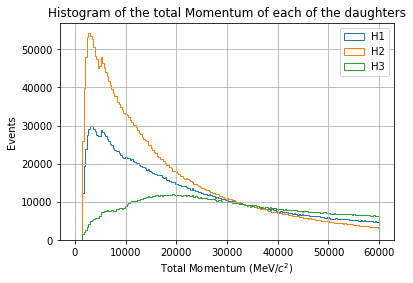

In [13]:
plt.hist(H1Ptot, bins= 200,  range=[0, 60000], histtype = 'step', label="H1")
plt.hist(H2Ptot, bins= 200,  range=[0, 60000], histtype = 'step', label="H2")
plt.hist(H3Ptot, bins= 200,  range=[0, 60000], histtype = 'step',  label="H3")
plt.xlabel("Total Momentum (MeV/$c^2$)")
plt.ylabel("Events")
plt.title("Histogram of the total Momentum of each of the daughters")
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Total momentum of mother
Momentum has to be conserved, the momentum of the mother particle is found by finding the magnitude of the total momentum of the daughter particles, given by the formula:
\begin{equation}
momentumMother=\sqrt{(H1_{PX}+H2_{PX}+H3_{PX})^2+(H1_{PY}+H2_{PY}+H3_{PY})^2+(H1_{PZ}+H2_{PZ}+H3_{PZ})^2} 
\end{equation}

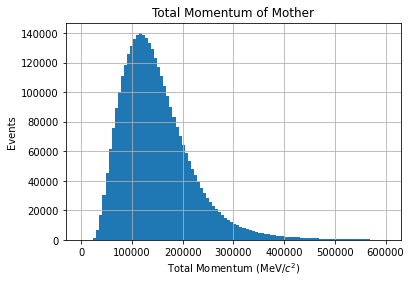

In [14]:
def momentumtot(component):#function which uses fstrings to find the sum of the momenta of the daughters in the specified direction
    return f.arrays(f"H1_P{component}+H2_P{component}+H3_P{component}", library="np")[f"H1_P{component}+H2_P{component}+H3_P{component}"]

momentumMother = np.sqrt(momentumtot("X")**2+momentumtot("Y")**2+momentumtot("Z")**2)#uses said function to find the momentum of the mother
 
plt.hist(momentumMother, bins= 100, range=[0, 600000])
plt.xlabel("Total Momentum (MeV/$c^2$)")
plt.ylabel("Events")
plt.title("Total Momentum of Mother")
plt.grid()
plt.show()

### Mass of B Meson
Due to the high velocities, the energy also gets a contribution from momentum. The relativistic Energy momentum relation says:

\begin{equation}E_{children}^2-p_{children}^2=m_{mother}^2\end{equation}
Where:

\begin{equation}E_{children}=E_1+E_2+E_3=\sqrt{p^2_1+m_1^2}+\sqrt{p^2_2+m_2^2}+\sqrt{p^2_3+m_3^2}\end{equation}
and
$$p_{children}=p_{mother}$$
Then, putting it all together
\begin{equation}
m_{mother}=\sqrt{\left(\sqrt{p^2_1+m_1^2}+\sqrt{p^2_2+m_2^2}+\sqrt{p^2_3+m_3^2}\right)^2-p_{mother}^2}
\end{equation}

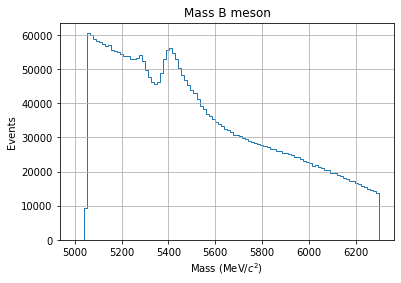

In [15]:
def energy(momentum):
    mass = 493.677 # mass of Kaon in MeV/c^2
    return np.sqrt(momentum**2+mass**2)

daughtersEnergy = energy(H1Ptot)+energy(H2Ptot)+energy(H3Ptot)

motherMass = np.sqrt(daughtersEnergy**2-momentumMother**2)

plt.hist(motherMass, bins= 100, histtype="step", range=[5000,6300])
plt.xlabel("Mass (MeV/$c^2$)")
plt.ylabel("Events")
plt.title("Mass B meson")
plt.grid()
plt.show()

experimentally determined rest mass of B-meson is: 5279.34±0.12 MeV/$c^2$
### Data Filtering

In [16]:
def probability(number, type):
    return f.arrays(f"H{number}_Prob{type}",library="np")[f'H{number}_Prob{type}']

def makeplots(type):
    plt.hist(probability(1, type), bins= 100, range=[0, 1], label="H1", histtype = 'step')
    plt.hist(probability(2, type), bins= 100, range=[0, 1], label="H2", histtype = 'step')
    plt.hist(probability(3, type), bins= 100, range=[0, 1], label="H3", histtype = 'step')
    plt.title(f"Probability of H1, H2 or H3 being a {type}")
    plt.ylabel("Events")
    plt.xlabel("Probability")
    plt.grid()
    plt.legend(loc="best")
    plt.show()


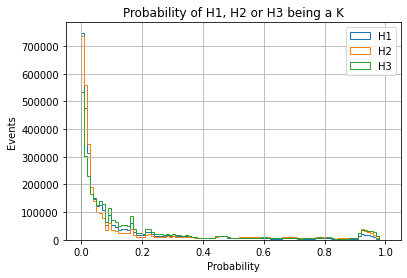

In [17]:
makeplots("K")

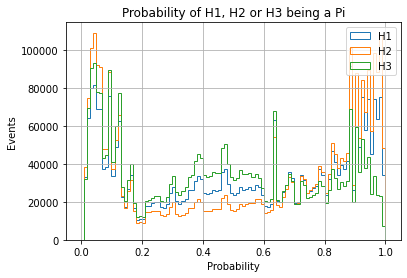

In [18]:
makeplots("Pi")

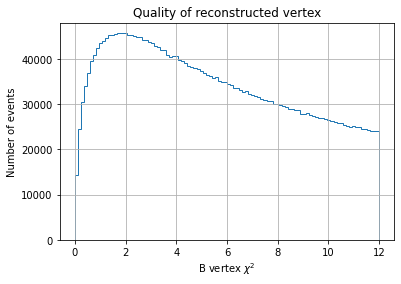

In [19]:
chi = f.arrays("B_VertexChi2", library="np")["B_VertexChi2"]
plt.hist(chi, bins=100, histtype="step")
plt.grid()
plt.xlabel("B vertex $\chi^2$")
plt.ylabel("Number of events")
plt.title("Quality of reconstructed vertex")
plt.show()

## Filtering the data set

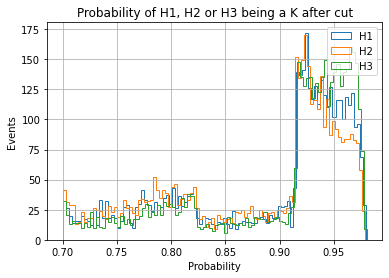

In [20]:
def filter(n):
    return f"(H{n}_ProbK>0.7)&(H{n}_isMuon==0)"

condition = f"{filter(1)}&{filter(2)}&{filter(3)}"
cut = f.arrays(cut=condition,library="np")

plt.hist(cut["H1_ProbK"], bins= 100,  label="H1", histtype = 'step')
plt.hist(cut["H2_ProbK"], bins= 100,  label="H2", histtype = 'step')
plt.hist(cut["H3_ProbK"], bins= 100,  label="H3", histtype = 'step')
plt.title(f"Probability of H1, H2 or H3 being a K after cut")
plt.ylabel("Events")
plt.xlabel("Probability")
plt.grid()
plt.legend(loc="best")
plt.show()

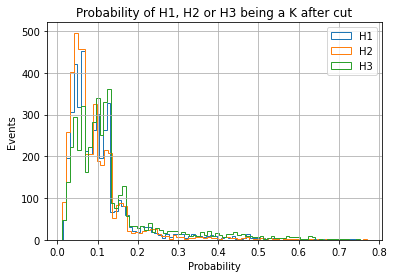

In [21]:
plt.hist(cut["H1_ProbPi"], bins= 80,  label="H1", histtype = 'step')
plt.hist(cut["H2_ProbPi"], bins= 80,  label="H2", histtype = 'step')
plt.hist(cut["H3_ProbPi"], bins= 80,  label="H3", histtype = 'step')
plt.title(f"Probability of H1, H2 or H3 being a K after cut")
plt.ylabel("Events")
plt.xlabel("Probability")
plt.grid()
plt.legend(loc="best")
plt.show()

In [22]:
def childMomentumCut(n):
    return np.sqrt(cut[f"H{n}_PX"]**2+cut[f"H{n}_PY"]**2+cut[f"H{n}_PZ"]**2)

def motherMomentumComponentCut(direction):
    return cut[f"H1_P{direction}"]+cut[f"H2_P{direction}"]+cut[f"H3_P{direction}"]

daughtersEnergyCut = energy(childMomentumCut(1))+energy(childMomentumCut(2))+energy(childMomentumCut(3))
motherMomentumCut = np.sqrt(motherMomentumComponentCut("X")**2+motherMomentumComponentCut("Y")**2+motherMomentumComponentCut("Z")**2)

motherMassCut = np.sqrt(daughtersEnergyCut**2-motherMomentumCut**2)


Since we cut the dataset, the number of datapoints in the cut version will be much lower than those in the uncut version so we need to take this into account when plotting the graphs. To make sure the graph is readable we therefore make two y-axes with different scales but the same x-axis

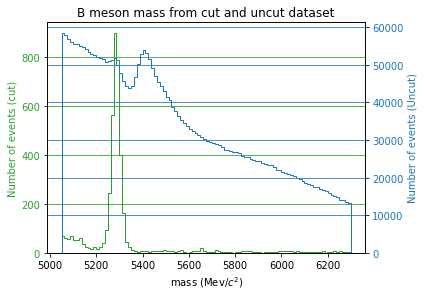

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('mass (Mev/$c^2$)')
ax1.set_ylabel('Number of events (cut)', color=color)
ax1.hist(motherMassCut, bins=100, color=color, histtype="step", label="cut")
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(axis='y', color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of events (Uncut)', color=color)
ax2.hist(motherMass, bins=100, color=color, histtype="step", label="uncut")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.grid(axis='y', color=color, which='both')
plt.grid(axis='x', color='g')
plt.title("B meson mass from cut and uncut dataset")
plt.show()

In [50]:
mmin, mmax= min(motherMassCut), max(motherMassCut)
m = np.linspace(mmin, mmax, 500)
hist, bins = np.histogram(motherMassCut, bins=200)



## Data Fitting
Typically exponential and Chebychev functions are used for background and Gaussian, Crystal Ball and Breit-Wigner are used for signal. We can also combine them (e.g. 1 crystal ball, 1 gaussian, 1 exponential) in various ways.

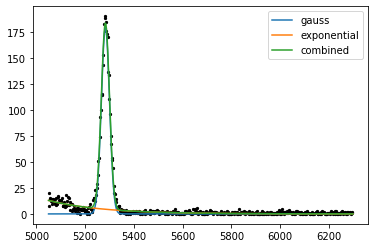

chi2 statistic:     0
p-value:            1
degrees of freedom: 0
expected frequencies:
[ 12.9676219   12.82052452  12.67509572  12.53131659  12.3891684
  12.24863267  12.10969109  11.97232559  11.83651828  11.7022515
  11.56950776  11.4382698   11.30852052  11.18024304  11.05342068
  10.92803691  10.80407543  10.68152009  10.56035495  10.44056425
  10.32213238  10.20504393  10.08928367   9.97483653   9.86168762
   9.7498222    9.63922572   9.52988378   9.42178216   9.31490678
   9.20924373   9.10477927   9.00149979   8.89939185   8.79844217
   8.69863761   8.59996518   8.50241202   8.40596546   8.31061293
   8.21634203   8.12314048   8.03099616   7.93989707   7.84983136
   7.7607873    7.67275331   7.58571793   7.49966984   7.41459785
   7.33049091   7.24733816   7.16512894   7.083853     7.00350073
   6.92406394   6.84553728   6.76792135   6.69122883   6.61549666
   6.54080915   6.46734078   6.39543337   6.32573058   6.25940569
   6.19853488   6.14668877   6.10983732   6.09768328   6

In [53]:
def gaussian( x,  mu, sigma, ampg):
    return ampg*stats.norm.pdf(x, mu, sigma)

def exponential(x, a,b,ampe):
    return ampe*stats.expon.pdf(x,a,b)

def model(x, mu, sigma,ampg, a,b, ampe):
    return gaussian(x, mu, sigma,ampg)+exponential(x, a,b,ampe)

mug,sigmag = stats.norm.fit(motherMassCut)
a,b = stats.expon.fit(motherMassCut)

dataentry, bins = np.histogram(motherMassCut, bins=500)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
pguess = [ mug,sigmag,25000, a,b, 25000]
parameters, covariance = curve_fit(model, xdata=bins[0:500], ydata=dataentry, p0=pguess)
print()
mu, sigma, ampg, a,b, ampe = parameters
plt.plot(m, gaussian(m, mu, sigma, ampg), label="gauss")
plt.plot(m, exponential(m, a, b, ampe), label="exponential")
plt.plot(m, model(m, mu, sigma, ampg, a,b, ampe), label="combined")
plt.scatter(bins[0:500], dataentry, color="black", s=5)
plt.legend()
plt.show()

# chi2, p, dof, expected = stats.chi2_contingency((model(bins[0:200], mu, sigma,ampg, a,b, ampe)))
# print(f"chi2 statistic:     {chi2:.5g}")
# print(f"p-value:            {p:.5g}")
# print(f"degrees of freedom: {dof}")
# print("expected frequencies:")
# print(expected)

### Counting

\begin{equation}
A^2 = \frac{\left(N^{B_-}-N^{B_+}\right)}{\left(N^{B_-}+N^{B_+}\right)}
\end{equation}

\begin{equation}
\sigma_A=\sqrt\frac{1-A^2}{N^{B-}+N^{B+}}
\end{equation}

In [28]:
def childrenCharge():
    return "H1_Charge+H2_Charge+H3_Charge"

# condition = f"{filter(1)}&{filter(2)}&{filter(3)}"
# cut = f.arrays(cut=condition,library="np")    
Nminus = len(f.arrays(cut=f"({childrenCharge()}==-1)&{condition}", library="pd"))
Nplus = len(f.arrays(cut=f"({childrenCharge()}==1)&{condition}", library="pd"))
print(Nplus)
print(Nminus)

def asymmetry(Nplus, Nminus):
    return (Nminus-Nplus)/(Nminus+Nplus)

def deviation(Nplus, Nminus):
    return np.sqrt((1-asymmetry(Nplus, Nminus)**2)/(Nminus+Nplus))

print("The deviation is:", deviation(Nminus,Nplus))
print("The Asymmetry is:", asymmetry(Nminus,Nplus))

2250
2106
The deviation is: 0.015143233937450318
The Asymmetry is: 0.03305785123966942
